In [1]:
#inline matplotlib
%matplotlib inline

#imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import copy

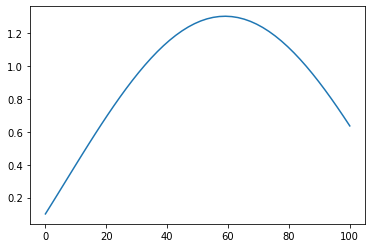

In [132]:
def function(afsb, t):
    return afsb[..., 0:1] * np.sin(afsb[..., 1:2] * t - afsb[..., 2:3]) + afsb[..., 3:4]

known_params = np.array([1,0.03,0.2,0.3])
X = np.linspace(0,100,50)
y = function(known_params, X)

plt.plot(X, y)
plt.show()

# Simple GA algorithm

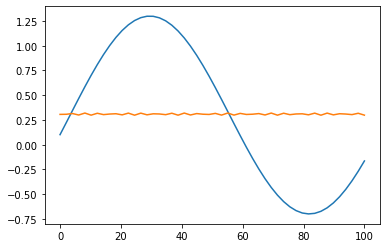

[0.01089961 4.41394876 2.88249438 0.30905868] 0.5100252906809286


In [130]:
population_count = 100
lower_limits = np.array([0, 0, 0, -1])
upper_limits = np.array([1, np.pi*2, np.pi*2, 1])
population = np.random.uniform(lower_limits, upper_limits, (population_count, 4))

def error(X, y, params):
    y_ = function(params, X)
    return np.sum((y - y_)**2, axis=-1) / X.shape[-1]

best_solution = population[0,:]
best_error = error(X, y, best_solution)
for i in range(1000):
    # compute the fitness
    population_error = error(X[np.newaxis,:], y, population)
    #print ('iteration {}, mean_error {}, min_error {}'.format(i, np.mean(population_error), np.min(population_error)))
        
    # select 10 best
    sorted_args = np.argsort(population_error, axis=0)
    #do we have better than the best ?
    if population_error[sorted_args[0]] < best_error:
        best_error = population_error[sorted_args[0]]
        best_solution = population[sorted_args[0]]
        
    # create parent population
    parents = np.zeros((10,4))
    parents[0, :] = best_solution
    parents[1:, :] = population[sorted_args[:9], :]
        
    new_population = np.zeros((100, 4))
    for i in range(10):
        for j in range(10):
            new_population[i*10+j,:] = (parents[i, :] + parents[j, :]) * 0.5
            
    # mutate
    new_population += np.random.uniform(-0.001, 0.001, population_count*4).reshape([population_count, 4])
    population = new_population
    
    
y_ = function(best_solution, X)

plt.plot(X, y)
plt.plot(X, y_)
plt.show()

print (best_solution, best_error)

# Mix PSO GA L-BFGS-B

https://ieeexplore.ieee.org/document/8449979

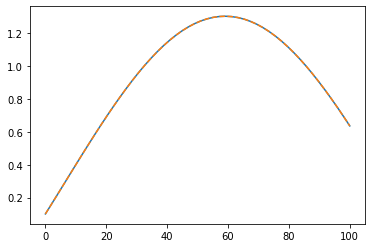

[0.99976144 6.18752556 0.20023027 0.30023484] 0.11221503645288676


In [134]:
population_count = 30
elite_count = 1
params_count = 4
velocity_rate = 0.001
lower_limits = np.array([0, 0, 0, -1])
upper_limits = np.array([1, np.pi*2, np.pi*2, 1])
bounds = np.array([(l,u) for l,u in zip(lower_limits, upper_limits)])

def error (params, X, y):
    y_ = function(params, X)
    return np.sum((y - y_)**2, axis=-1) / X.shape[-1]

def extinctions(fitness):
    return (swarm_fitness + np.min(swarm_fitness) * (((params_count - 1.0) / (population_count - 1.0)) - 1.0)) / np.max(swarm_fitness)

# initial population
swarm_positions = np.random.uniform(lower_limits, upper_limits, (population_count, params_count))
swarm_velocities = np.random.uniform(-0.1, 0.1, population_count * params_count).reshape((population_count, params_count))
swarm_fitness = error(swarm_positions, X[np.newaxis,:], y)
swarm_extinction = extinctions(swarm_fitness)
swarm_sorted_args = np.argsort(swarm_fitness, axis=0)

# global best
solution = swarm_positions[swarm_sorted_args[0], ...]
best_fitness = swarm_fitness[swarm_sorted_args[0]]

# iterate
for epoch in range(50):
    # early exit if close enough
    if best_fitness < 1e-6:
        break

    # pick elites and do a gradient descent using l-bfgs-b algorithm
    for e in range(elite_count):
        x, _, _ = scipy.optimize.fmin_l_bfgs_b(
            func=error, 
            x0=swarm_positions[swarm_sorted_args[e], ...], 
            args=(X[np.newaxis,:], y), 
            approx_grad=True, 
            bounds=bounds, 
            maxiter=100)
        swarm_velocities[swarm_sorted_args[e], ...] = np.random.uniform() * swarm_velocities[swarm_sorted_args[e], ...] + \
                                                    x - swarm_positions[swarm_sorted_args[e], ...]
        swarm_positions[swarm_sorted_args[e], ...] = x
        
    # try update solution
    if swarm_fitness[swarm_sorted_args[0]] < best_fitness:
        best_fitness = swarm_fitness[swarm_sorted_args[0]]
        solution = swarm_positions[swarm_sorted_args[0], ...]
        
    # create the offsprings
    offspring_positions = np.zeros((population_count, params_count), dtype=np.float32)
    offspring_velocities = np.zeros((population_count, params_count), dtype=np.float32)
    offspring_fitness = np.zeros(population_count, dtype=np.float32)
    
    # populate offsprings
    for off in range(population_count):
        parents_count = len(swarm_sorted_args)
        
        # rank based selection
        probabilities = np.array([parents_count-i for i in range(parents_count)], dtype=np.float32)
        probabilities /= np.sum(probabilities)
        a, b, prot = np.random.choice(swarm_sorted_args, 3, p=probabilities, replace=False)
            
        # combine parents
        mix_values = np.random.uniform(size=params_count)
        offspring_positions[off, :] = swarm_positions[a, :] * mix_values + \
            swarm_positions[b, :] * (1.0-mix_values)

        # add a bit of the velocity from the parents
        offspring_positions[off, :] += velocity_rate * (swarm_velocities[a, :] + swarm_velocities[b, :])

        # use the velocities from the parents
        offspring_velocities[off, :] = np.random.uniform(size=params_count) * swarm_velocities[a, :] + \
                                        np.random.uniform(size=params_count) * swarm_velocities[b, :]

        # mutate
        p = (np.mean(swarm_extinction[[a,b]]) * (params_count-1.0) + 1.0) / params_count
        if p < np.random.uniform():
            swarm_min = np.min(swarm_positions, axis=0)
            swarm_max = np.max(swarm_positions, axis=0)
            x = np.random.uniform(-1, 1, size=params_count) * np.mean(swarm_extinction[[a,b]]) * (swarm_max - swarm_min)
            offspring_velocities[off, :] += x
            offspring_positions[off, :] += x

        # adoption
        mix_values = np.random.uniform(size=params_count)
        average_parents = np.mean(swarm_positions[[a, b], :], axis=0)
        x = mix_values * (average_parents - offspring_positions[off, :])
        mix_values = np.random.uniform(size=params_count)
        x += mix_values * (offspring_positions[prot, :] - offspring_positions[off, :])
        offspring_velocities[off, :] += x
        offspring_positions[off, :] += x
        
        # clip
        offspring_positions[off, :] = np.clip(offspring_positions[off, :], a_min=lower_limits, a_max=upper_limits)
        
        # compute fitness of this offspring
        offspring_fitness[off] = error(offspring_positions[off, :], X, y)

        
    # assign offsprings to population
    swarm_positions = offspring_positions
    swarm_velocities = offspring_velocities
    swarm_fitness = offspring_fitness
    
    
    # sort everyone
    swarm_sorted_args = np.argsort(swarm_fitness, axis=0)
    swarm_extinction = extinctions(swarm_fitness)
    
    # try update solution
    if swarm_fitness[swarm_sorted_args[0]] < best_fitness:
        best_fitness = swarm_fitness[swarm_sorted_args[0]]
        solution = swarm_positions[swarm_sorted_args[0], ...]
    

y_ = function(solution, X)

plt.plot(X, y)
plt.plot(X, y_, linestyle='dashed')
plt.show()

print (solution, best_fitness)

# Mix PSO GA Gradient


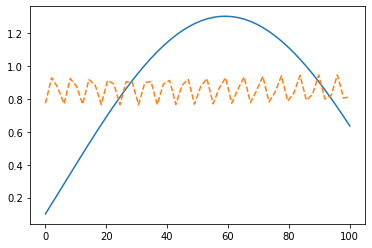

[0.0905019  5.14575591 2.00795674 0.85408446] 0.06190003837901127


In [138]:
population_count = 30
elite_count = 1
params_count = 4
velocity_rate = 0.001
lower_limits = np.array([0, 0, 0, -1])
upper_limits = np.array([1, np.pi*2, np.pi*2, 1])
bounds = np.array([(l,u) for l,u in zip(lower_limits, upper_limits)])

def function(afsb, t):
    return afsb[..., 0:1] * np.sin(afsb[..., 1:2] * t - afsb[..., 2:3]) + afsb[..., 3:4]

def error (afsb, X, y):
    y_ = function(afsb, X)
    return np.sum((y - y_)**2, axis=-1) / ( 2.0 * X.shape[-1])

def error_derivate (afsb, X, y):
    y_ = function(afsb, X)
    a, f, s, b = afsb[..., 0:1], afsb[..., 1:2], afsb[..., 2:3], afsb[..., 3:4]
    dsin = np.sin(f * X - s)
    dcos = np.cos(f * X - s)
    
    size = afsb.shape[0] if len(afsb.shape) > 1 else 1
    gradient = np.zeros((size, 4))
    gradient[:, 0] = np.sum((y - y_) * dsin, axis=-1) / ( X.shape[-1])
    gradient[:, 1] = np.sum((y - y_) * a * X * dcos, axis=-1) / ( X.shape[-1])
    gradient[:, 2] = np.sum((y - y_) * -a * dcos, axis=-1) / ( X.shape[-1])
    gradient[:, 3] = np.sum((y - y_), axis=-1) / ( X.shape[-1])
    return gradient

def extinctions(fitness):
    return (swarm_fitness + np.min(swarm_fitness) * (((params_count - 1.0) / (population_count - 1.0)) - 1.0)) / np.max(swarm_fitness)

# initial population
swarm_positions = np.random.uniform(lower_limits, upper_limits, (population_count, params_count))
swarm_velocities = np.random.uniform(-0.1, 0.1, population_count * params_count).reshape((population_count, params_count))
swarm_fitness = error(swarm_positions, X[np.newaxis,:], y)
swarm_extinction = extinctions(swarm_fitness)
swarm_sorted_args = np.argsort(swarm_fitness, axis=0)

# global best
solution = swarm_positions[swarm_sorted_args[0], ...]
best_fitness = swarm_fitness[swarm_sorted_args[0]]

# iterate
for epoch in range(50):
    # early exit if close enough
    if best_fitness < 1e-6:
        break

    # pick elites and do a gradient descent 
    x = copy.deepcopy(swarm_positions[swarm_sorted_args[:e], :])
    for gr_e in range(500):
        gradient = error_derivate(x, X[np.newaxis,:], y)
        x += 0.001 * gradient
    swarm_velocities[swarm_sorted_args[:e], :] = np.random.uniform() * swarm_velocities[swarm_sorted_args[:e], :] + \
                                                x - swarm_positions[swarm_sorted_args[:e], :]
    swarm_positions[swarm_sorted_args[:e], :] = x
        
    # try update solution
    if swarm_fitness[swarm_sorted_args[0]] < best_fitness:
        best_fitness = swarm_fitness[swarm_sorted_args[0]]
        solution = swarm_positions[swarm_sorted_args[0], ...]
        
    # create the offsprings
    offspring_positions = np.zeros((population_count, params_count), dtype=np.float32)
    offspring_velocities = np.zeros((population_count, params_count), dtype=np.float32)
    offspring_fitness = np.zeros(population_count, dtype=np.float32)
    
    # populate offsprings
    for off in range(population_count):
        parents_count = len(swarm_sorted_args)
        
        # rank based selection
        probabilities = np.array([parents_count-i for i in range(parents_count)], dtype=np.float32)
        probabilities /= np.sum(probabilities)
        a, b, prot = np.random.choice(swarm_sorted_args, 3, p=probabilities, replace=False)
            
        # combine parents
        mix_values = np.random.uniform(size=params_count)
        offspring_positions[off, :] = swarm_positions[a, :] * mix_values + \
            swarm_positions[b, :] * (1.0-mix_values)

        # add a bit of the velocity from the parents
        offspring_positions[off, :] += velocity_rate * (swarm_velocities[a, :] + swarm_velocities[b, :])

        # use the velocities from the parents
        offspring_velocities[off, :] = np.random.uniform(size=params_count) * swarm_velocities[a, :] + \
                                        np.random.uniform(size=params_count) * swarm_velocities[b, :]

        # mutate
        p = (np.mean(swarm_extinction[[a,b]]) * (params_count-1.0) + 1.0) / params_count
        if p < np.random.uniform():
            swarm_min = np.min(swarm_positions, axis=0)
            swarm_max = np.max(swarm_positions, axis=0)
            x = np.random.uniform(-1, 1, size=params_count) * np.mean(swarm_extinction[[a,b]]) * (swarm_max - swarm_min)
            offspring_velocities[off, :] += x
            offspring_positions[off, :] += x

        # adoption
        mix_values = np.random.uniform(size=params_count)
        average_parents = np.mean(swarm_positions[[a, b], :], axis=0)
        x = mix_values * (average_parents - offspring_positions[off, :])
        mix_values = np.random.uniform(size=params_count)
        x += mix_values * (offspring_positions[prot, :] - offspring_positions[off, :])
        offspring_velocities[off, :] += x
        offspring_positions[off, :] += x
        
        # clip
        offspring_positions[off, :] = np.clip(offspring_positions[off, :], a_min=lower_limits, a_max=upper_limits)
        
        # compute fitness of this offspring
        offspring_fitness[off] = error(offspring_positions[off, :], X, y)

        
    # assign offsprings to population
    swarm_positions = offspring_positions
    swarm_velocities = offspring_velocities
    swarm_fitness = offspring_fitness
    
    
    # sort everyone
    swarm_sorted_args = np.argsort(swarm_fitness, axis=0)
    swarm_extinction = extinctions(swarm_fitness)
    
    # try update solution
    if swarm_fitness[swarm_sorted_args[0]] < best_fitness:
        best_fitness = swarm_fitness[swarm_sorted_args[0]]
        solution = swarm_positions[swarm_sorted_args[0], ...]
    

y_ = function(solution, X)

plt.plot(X, y)
plt.plot(X, y_, linestyle='dashed')
plt.show()

print (solution, best_fitness)

# PSO


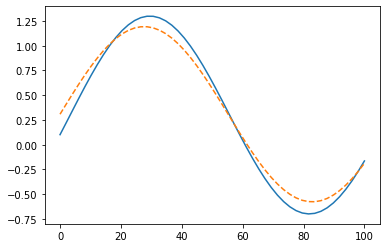

[0.88557509 3.13564181 6.28318531 0.30796639] 0.00983247511126656
[[0.88557509 3.13564181 6.28318531 0.30796639]
 [0.88557509 3.13564181 6.28318531 0.30796639]
 [0.88557509 3.13564181 6.28318531 0.30796639]
 [0.88557509 3.13564181 6.28318531 0.30796639]
 [0.88557509 3.13564181 6.28318531 0.30796639]]


In [127]:
population_count = 100
params_count = 4
w=0.5       # constant inertia weight (how much to weight the previous velocity)
c1=0.2        # cognative constant
c2=0.4        # social constant
        
lower_limits = np.array([0, 0, 0, -1])
upper_limits = np.array([1, np.pi*2, np.pi*2, 1])

def error(params, X, y):
    y_ = function(params, X)
    return np.sum((y - y_)**2, axis=-1) / X.shape[-1]

population_positions = np.random.uniform(lower_limits, upper_limits, (population_count, params_count))
population_velocities = np.random.uniform(-1, 1, (population_count, params_count))
population_best = np.zeros((population_count, params_count))
population_fitness_best = np.ones(population_count) * np.inf

solution = population_positions[0, :]
best_fitness = population_fitness_best[0]

for i in range(1000):
    
    # update fitness
    population_fitness = error(population_positions, X[np.newaxis,:], y)
    
    # check if we have new best fitness
    is_better = population_fitness < population_fitness_best
    population_best[is_better, :] = population_positions[is_better, :]
    population_fitness_best[is_better] = population_fitness[is_better]
    
    # update global best
    sorted_population_args = np.argsort(population_fitness, axis=0)
    if population_fitness[sorted_population_args[0]] < best_fitness:
        solution = population_positions[sorted_population_args[0], ...]
        best_fitness = population_fitness[sorted_population_args[0]]
        #print (best_fitness)
        
    # update velocities
    r1=np.random.uniform(0, 1, (population_count, params_count))
    r2=np.random.uniform(0, 1, (population_count, params_count))

    vel_cognitive = c1 * r1 * (population_best - population_positions)
    vel_social= c2 * r2 * (solution - population_positions)
    population_velocities = w * population_velocities + vel_cognitive + vel_social
    
    # update positions
    population_positions += population_velocities
    for p in range(population_count):
        population_positions[p, :] = np.clip(population_positions[p, :], a_min=lower_limits, a_max=upper_limits)
        

y_ = function(solution, X)

plt.plot(X, y)
plt.plot(X, y_, linestyle='dashed')
plt.show()

print (solution, best_fitness)
print (population_positions[sorted_population_args[:5]])

# Hill Climbing
We will do a hill climbing with several points at the same time to hopefully get several local minima and find the best one


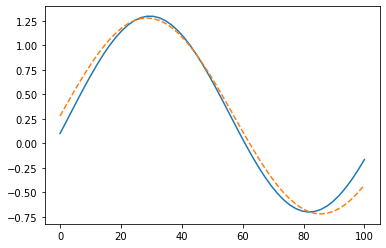

[1.         3.13376963 6.28318531 0.28072926]


In [120]:
population_count = 200
params_count = 4        
lower_limits = np.array([0, 0, 0, -1])
upper_limits = np.array([1, np.pi*2, np.pi*2, 1])
population = np.random.uniform(lower_limits, upper_limits, (population_count, params_count))
fitness = error(population, X[np.newaxis,:], y)

lower_limits = lower_limits[np.newaxis, :] * np.ones((population_count,1))
upper_limits = upper_limits[np.newaxis, :] * np.ones((population_count,1))
steps_size = (upper_limits - lower_limits) * 0.1


def function(afsb, t):
    return afsb[..., 0:1] * np.sin(afsb[..., 1:2] * t - afsb[..., 2:3]) + afsb[..., 3:4]

def error (params, X, y):
    y_ = function(params, X)
    return np.sum((y - y_)**2, axis=-1) / (2*X.shape[-1])

for epoch in range(1000):
    new_population = np.random.normal(population, steps_size)
    new_population = np.clip(new_population, a_min=lower_limits, a_max=upper_limits)
    new_fitness = error(new_population, X[np.newaxis,:], y)
    is_better = new_fitness < fitness
    population[is_better] = new_population[is_better]
    fitness[is_better] = new_fitness[is_better]
    
    
sorted_args = np.argsort(fitness, axis=0)
    
y_ = function(population[sorted_args[0]], X)

plt.plot(X, y)
plt.plot(X, y_, linestyle='dashed')
plt.show()

print(population[sorted_args[0]])



# Gradient descent with derivate
Partial derivatie of the cost function.<br>
https://mccormickml.com/2014/03/04/gradient-descent-derivation/

#### function
$f_{a,f,s,b}(t) = a . sin(f . t - s) + b$

#### cost mean square
$\frac{1}{2 . m} \sum_{i=1}^m ((f(t_{i}) - y_{i})^2$

#### derivative of cost
* 
$\frac{1}{m}\sum_{i=1}^m (f(t_{i}) - y_{i}) * f'(t_{i})$

#### partial derivative of function
$f_{a,f,s,b}(t) = a . sin(f . t - s) + b$<br>
$\frac{\partial}{\partial a} = sin(f . t - s)$<br>
$\frac{\partial}{\partial f} = a . t . cos(f . t - s)$<br>
$\frac{\partial}{\partial s} = -a . cos(f . t - s)$<br>
$\frac{\partial}{\partial b} = 1$<br>


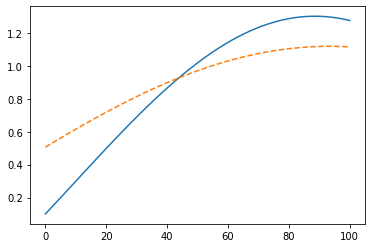

In [72]:
def function(afsb, t):
    return afsb[..., 0:1] * np.sin(afsb[..., 1:2] * t - afsb[..., 2:3]) + afsb[..., 3:4]

def error (afsb, X, y):
    y_ = function(afsb, X)
    return np.sum((y - y_)**2, axis=-1) / ( 2.0 * X.shape[-1])

def error_derivate (afsb, X, y):
    y_ = function(afsb, X)
    a, f, s, b = afsb[..., 0:1], afsb[..., 1:2], afsb[..., 2:3], afsb[..., 3:4]
    dsin = np.sin(f * X - s)
    dcos = np.cos(f * X - s)
    
    size = afsb.shape[0] if len(afsb.shape) > 1 else 1
    gradient = np.zeros((size, 4))
    gradient[:, 0] = np.sum((y - y_) * dsin, axis=-1) / ( X.shape[-1])
    gradient[:, 1] = np.sum((y - y_) * a * X * dcos, axis=-1) / ( X.shape[-1])
    gradient[:, 2] = np.sum((y - y_) * -a * dcos, axis=-1) / ( X.shape[-1])
    gradient[:, 3] = np.sum((y - y_), axis=-1) / ( X.shape[-1])
    return gradient
    
population_count = 100
lower_limits = np.array([0, 0, 0, -1])
upper_limits = np.array([1, np.pi*2, np.pi*2, 1])
afbs = np.random.uniform(lower_limits, upper_limits, (population_count, 4))

for epoch in range(2000):
    gradient = error_derivate(afbs, X[np.newaxis,:], y)
    afbs += 0.001 * gradient

sorted_args = np.argsort(error(afbs, X[np.newaxis,:], y), axis=0)
y_ = function(afbs[sorted_args[0]], X)
plt.plot(X, y)
plt.plot(X, y_, linestyle='dashed')
plt.show()

# Hill Climbing + Gradient


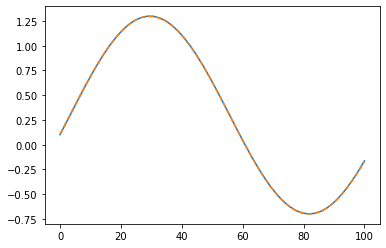

[0.99906211 3.01888509 2.94919109 0.29889753]


In [108]:
population_count = 100
params_count = 4        
lower_limits = np.array([0, 0, 0, -1])
upper_limits = np.array([1, np.pi*2, np.pi*2, 1])
population = np.random.uniform(lower_limits, upper_limits, (population_count, params_count))
fitness = error(population, X[np.newaxis,:], y)

lower_limits = lower_limits[np.newaxis, :] * np.ones((population_count,1))
upper_limits = upper_limits[np.newaxis, :] * np.ones((population_count,1))
steps_size = (upper_limits - lower_limits) * 0.1

def function(afsb, t):
    return afsb[..., 0:1] * np.sin(afsb[..., 1:2] * t - afsb[..., 2:3]) + afsb[..., 3:4]

def error (afsb, X, y):
    y_ = function(afsb, X)
    return np.sum((y - y_)**2, axis=-1) / ( 2.0 * X.shape[-1])

def error_derivate (afsb, X, y):
    y_ = function(afsb, X)
    a, f, s, b = afsb[..., 0:1], afsb[..., 1:2], afsb[..., 2:3], afsb[..., 3:4]
    dsin = np.sin(f * X - s)
    dcos = np.cos(f * X - s)
    
    size = afsb.shape[0] if len(afsb.shape) > 1 else 1
    gradient = np.zeros((size, 4))
    gradient[:, 0] = np.sum((y - y_) * dsin, axis=-1) / ( X.shape[-1])
    gradient[:, 1] = np.sum((y - y_) * a * X * dcos, axis=-1) / ( X.shape[-1])
    gradient[:, 2] = np.sum((y - y_) * -a * dcos, axis=-1) / ( X.shape[-1])
    gradient[:, 3] = np.sum((y - y_), axis=-1) / ( X.shape[-1])
    return gradient

for epoch in range(2000):
    new_population = np.random.normal(population, steps_size)
    new_population = np.clip(new_population, a_min=lower_limits, a_max=upper_limits)
    new_fitness = error(new_population, X[np.newaxis,:], y)
    is_better = new_fitness < fitness
    population[is_better] = new_population[is_better]
    fitness[is_better] = new_fitness[is_better]
    
sorted_args = np.argsort(fitness, axis=0)
population_count = 50
population = population[sorted_args[:population_count], :]
for epoch in range(5000):
    gradient = error_derivate(population, X[np.newaxis,:], y)
    population += 0.001 * gradient

    
sorted_args = np.argsort(error(population, X[np.newaxis,:], y), axis=0)
y_ = function(population[sorted_args[0]], X)
plt.plot(X, y)
plt.plot(X, y_, linestyle='dashed')
plt.show()
print (population[sorted_args[0]])